# Flight Price Prediction with XGBoost
- Kaggle Dataset: https://www.kaggle.com/nikhilmittal/flight-fare-prediction-mh

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from chart_studio.plotly import plot,iplot
import pandas_profiling as pf # for automated EDA
import cufflinks as cf
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [29]:
data = pd.read_excel('datasets/Data_Train.xlsx')

In [4]:
data.shape

(10683, 11)

In [5]:
data.head()

Airline Date_of_Journey    Source Destination                  Route  \
0       IndiGo      24/03/2019  Banglore   New Delhi              BLR → DEL   
1    Air India       1/05/2019   Kolkata    Banglore  CCU → IXR → BBI → BLR   
2  Jet Airways       9/06/2019     Delhi      Cochin  DEL → LKO → BOM → COK   
3       IndiGo      12/05/2019   Kolkata    Banglore        CCU → NAG → BLR   
4       IndiGo      01/03/2019  Banglore   New Delhi        BLR → NAG → DEL   

  Dep_Time  Arrival_Time Duration Total_Stops Additional_Info  Price  
0    22:20  01:10 22 Mar   2h 50m    non-stop         No info   3897  
1    05:50         13:15   7h 25m     2 stops         No info   7662  
2    09:25  04:25 10 Jun      19h     2 stops         No info  13882  
3    18:05         23:30   5h 25m      1 stop         No info   6218  
4    16:50         21:35   4h 45m      1 stop         No info  13302

### EDA part

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [77]:
data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [7]:
pf.ProfileReport(data) #automated EDA

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [30]:
data.dropna(axis=0, inplace=True) # Drop NA values

### Feature Engineering
- convert **Date_of_Journey** to its appropriate format as **datetime** with regards to **day** and **month**

In [31]:
data['Date_of_Journey'] = pd.to_datetime(data['Date_of_Journey'])
data['Day_of_Journey'] = (data['Date_of_Journey']).dt.day
data['Month_of_Journey'] =(data['Date_of_Journey']).dt.month

In [32]:
data.drop(['Date_of_Journey'], axis =1, inplace=True) # no need anymore

#### Dep_Time

In [33]:
data['Dep_hr'] = pd.to_datetime(data['Dep_Time']).dt.hour
data['Dep_min'] = pd.to_datetime(data['Dep_Time']).dt.minute

In [34]:
data.drop(['Dep_Time'], axis =1, inplace=True) # no need anymore

#### Arrival_Time

In [35]:
data['Arrival_hr'] = pd.to_datetime(data['Arrival_Time']).dt.hour
data['Arrival_min'] = pd.to_datetime(data['Arrival_Time']).dt.minute

In [36]:
data.drop(['Arrival_Time'], axis =1, inplace=True) # no need anymore

#### Handling Duration

In [37]:
# 2h 50m as example.
duration = data['Duration'].str.split(' ', expand=True) #split duration datapoints based on space ' '
duration[1].fillna('00m',inplace=True) # filling all NaN with 00m
data['duration_hr'] = duration[0].apply(lambda x: x[:-1]) #select the item at index 0 and leave the last one (in this case the 'h')
data['duration_min'] = duration[1].apply(lambda x: x[:-1]) #select the item at index 1 and leave the last one (in this case the 'm')

In [38]:
data.drop(["Duration"],axis=1,inplace=True)

In [39]:
cf.set_config_file(theme='ggplot',sharing='public',offline=True)

#### Count of Airlines

In [45]:
data['Airline'].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1752
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

#### Airlines vs Prices

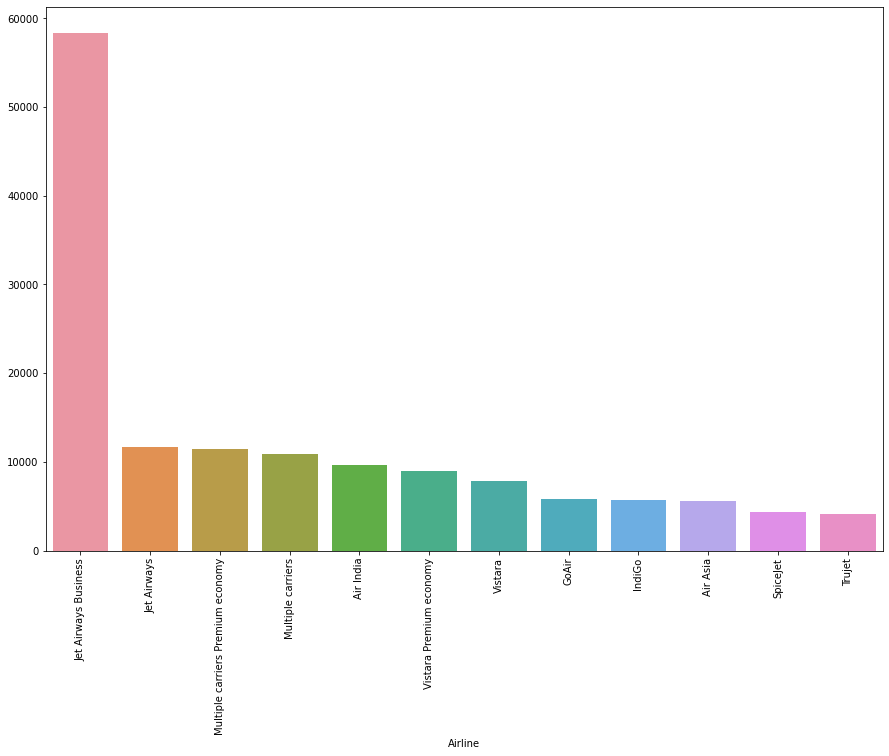

In [59]:
AirPrices = data.groupby('Airline')['Price'].mean().sort_values(ascending=False)
plt.figure(figsize=(15,10))
sns.barplot(AirPrices.index, AirPrices.values)
plt.xticks(rotation=90);

- Jet Airways Business has the highest price with Trujet having the lowest

In [54]:
AirPrices

Airline
Jet Airways Business                 58358.666667
Jet Airways                          11643.923357
Multiple carriers Premium economy    11418.846154
Multiple carriers                    10902.678094
Air India                             9611.210616
Vistara Premium economy               8962.333333
Vistara                               7796.348643
GoAir                                 5861.056701
IndiGo                                5673.682903
Air Asia                              5590.260188
SpiceJet                              4338.284841
Trujet                                4140.000000
Name: Price, dtype: float64

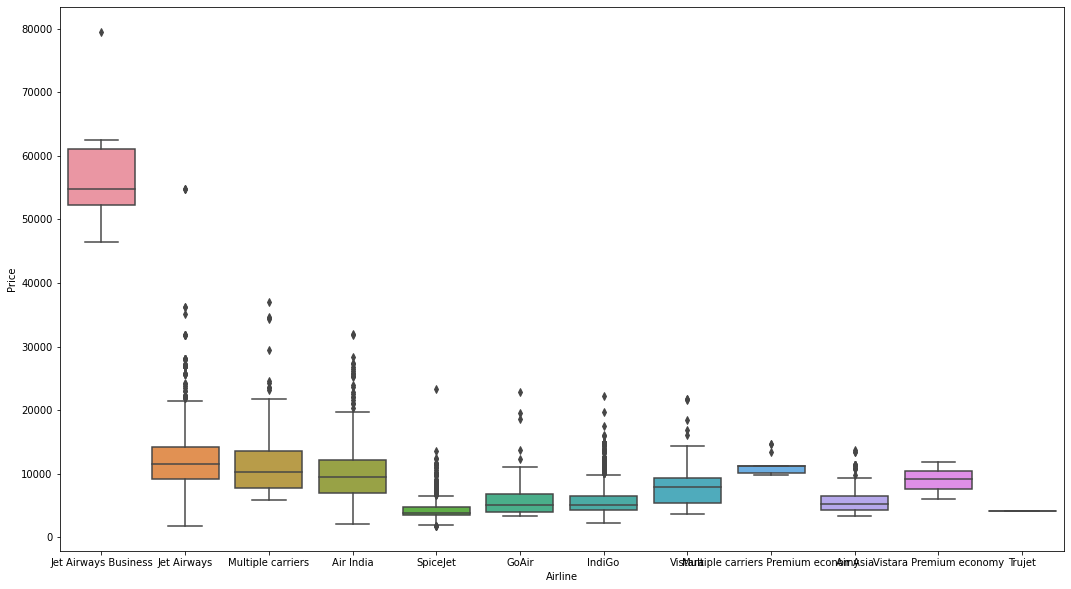

In [61]:
plt.figure(figsize=(18,10))
sns.boxplot(y='Price',x='Airline',data= data.sort_values('Price',ascending=False))
plt.show();

#### Price based on number of stops

In [88]:
data.groupby(['Airline', 'Total_Stops'])['Price'].mean()

Airline                            Total_Stops
Air Asia                           1 stop          7078.325581
                                   2 stops         6341.888889
                                   non-stop        4492.331492
Air India                          1 stop          9041.509259
                                   2 stops        12092.779101
                                   3 stops        12208.054054
                                   4 stops        17686.000000
                                   non-stop        5605.326139
GoAir                              1 stop          6884.676471
                                   non-stop        4726.173913
IndiGo                             1 stop          7104.717528
                                   2 stops         7507.526316
                                   non-stop        4731.174053
Jet Airways                        1 stop         12512.741223
                                   2 stops        13387.247467
        

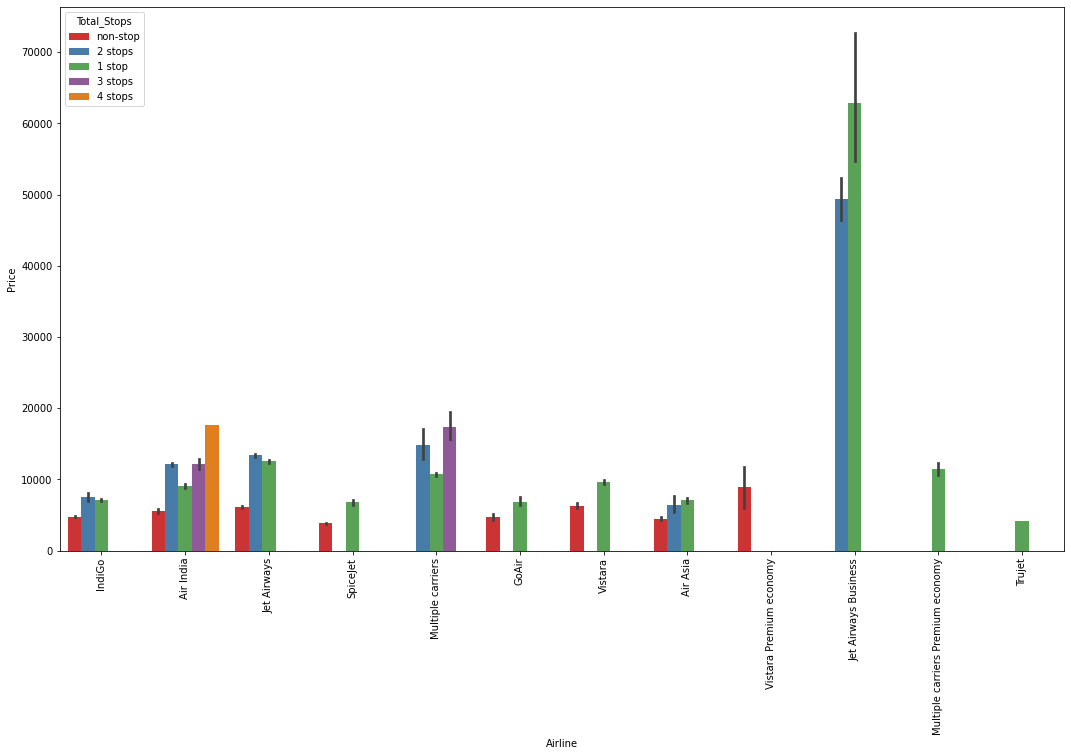

In [63]:
plt.figure(figsize=(18,10))
ax=sns.barplot(x=data['Airline'],y=data['Price'],hue=data['Total_Stops'],palette="Set1")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show();

- One stop and two stpos **Jet Airways Business** is having the highest price

#### Source vs Price

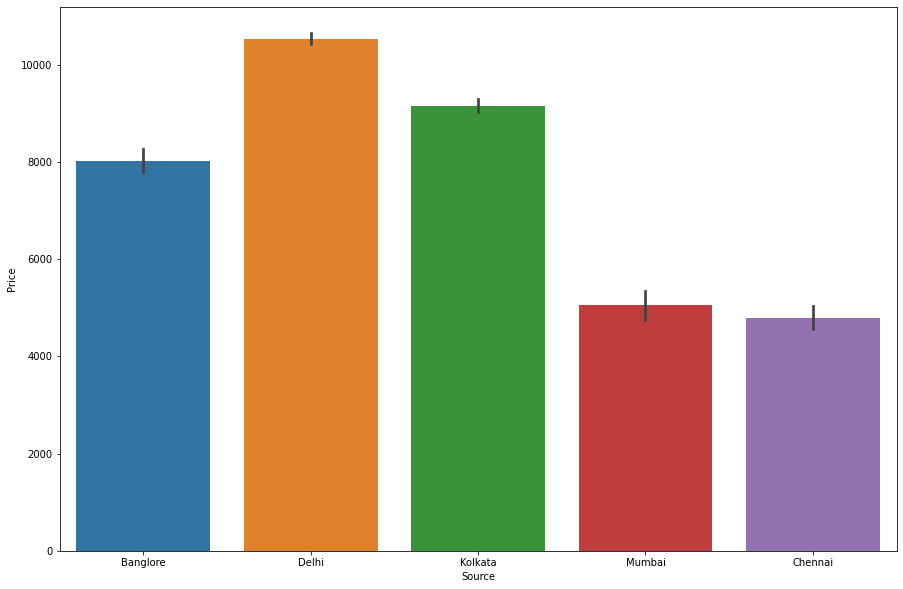

In [65]:
plt.figure(figsize=(15,10))
sns.barplot(y='Price',x='Source',data=data.sort_values('Price',ascending=False))
plt.show();

#### Destination vs Price

In [40]:
# In Destination col has 'New Delhi'. converted it to Delhi
for i in data:
    data.replace('New Delhi','Delhi',inplace=True)

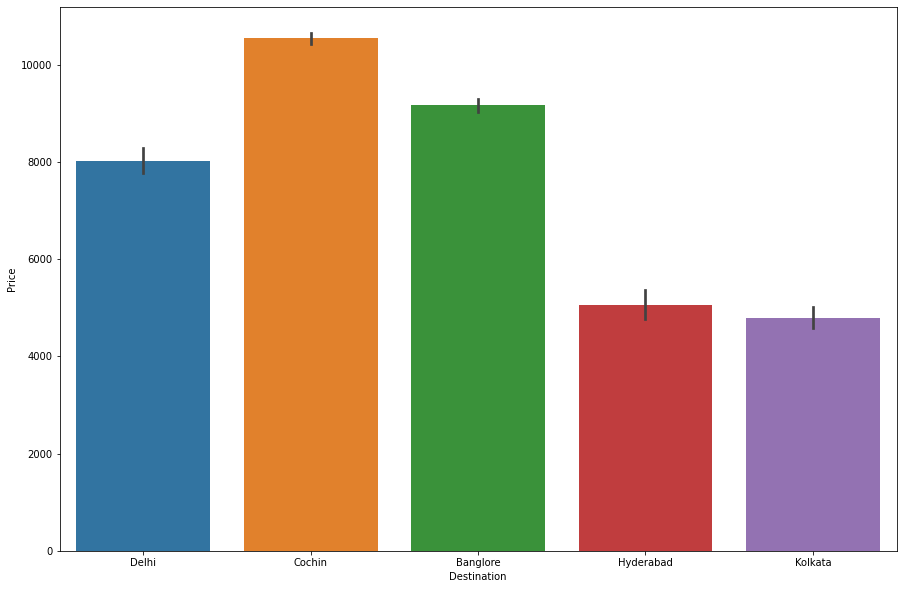

In [90]:
plt.figure(figsize=(15,10))
sns.barplot(y='Price',x='Destination',data=data.sort_values('Price',ascending=False))
plt.show();

### Apply Onehot Encoding on the categorical variables

In [41]:
#Handling Categorical Values 
data['Total_Stops']=data['Total_Stops'].map({'non-stop':0, '2 stops':2, '1 stop':1, '3 stops':3, '4 stops':4})
air_dummy=pd.get_dummies(data['Airline'],drop_first=True)

In [42]:
source_dest_dummy=pd.get_dummies(data[['Source','Destination']],drop_first=True)
data=pd.concat([air_dummy,source_dest_dummy,data],axis=1)

In [43]:
data.drop(['Airline','Source','Destination'],inplace=True,axis=1)

In [17]:
data.head()

Air India  GoAir  IndiGo  Jet Airways  Jet Airways Business  \
0          0      0       1            0                     0   
1          1      0       0            0                     0   
2          0      0       0            1                     0   
3          0      0       1            0                     0   
4          0      0       1            0                     0   

   Multiple carriers  Multiple carriers Premium economy  SpiceJet  Trujet  \
0                  0                                  0         0       0   
1                  0                                  0         0       0   
2                  0                                  0         0       0   
3                  0                                  0         0       0   
4                  0                                  0         0       0   

   Vistara  ...  Additional_Info  Price  Day_of_Journey  Month_of_Journey  \
0        0  ...          No info   3897              24                 3   
1        0  ...          No info   7662               5                 1   
2        0  ...          No info  13882               6                 9   
3        0  ...          No info   6218               5                12   
4        0  ...          No info  13302               3                 1   

   Dep_hr  Dep_min  Arrival_hr  Arrival_min  duration_hr duration_min  
0      22       20           1           10            2           50  
1       5       50          13           15            7           25  
2       9       25           4           25           19           00  
3      18        5          23           30            5           25  
4      16       50          21           35            4           45  

[5 rows x 31 columns]

In [47]:
data.drop(['Additional_Info',"Route"], inplace=True,axis=1)

In [52]:
# we dont need 'Additional_Info'and "Route" features for this study
print('train_shape',data.shape)

train_shape (10682, 29)


In [48]:
data['duration_hr'] = data['duration_hr'].astype(int) #for train data
data['duration_min'] = data['duration_min'].astype(int)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 29 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Air India                          10682 non-null  uint8
 1   GoAir                              10682 non-null  uint8
 2   IndiGo                             10682 non-null  uint8
 3   Jet Airways                        10682 non-null  uint8
 4   Jet Airways Business               10682 non-null  uint8
 5   Multiple carriers                  10682 non-null  uint8
 6   Multiple carriers Premium economy  10682 non-null  uint8
 7   SpiceJet                           10682 non-null  uint8
 8   Trujet                             10682 non-null  uint8
 9   Vistara                            10682 non-null  uint8
 10  Vistara Premium economy            10682 non-null  uint8
 11  Source_Chennai                     10682 non-null  uint8
 12  Source_Delhi      

### Model Building and Hyperparameter Tuning Part

In [162]:
X=data.drop(['Price'],axis=1)
y=data['Price']

In [163]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

from pycaret.regression import *

In [164]:
train, test = train_test_split(data, test_size=.2, random_state=1)

In [165]:
reg = setup(data=train, target = 'Price',
            fold_strategy= 'kfold',
            fold =10,
            silent = True
           )

In [166]:
best_model = compare_models()

### Modelling with Sklearn
- I will try **lightGBM** , **XGboost**  and **CatBoost** algorithms to reach best fit model

In [167]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= .25, random_state = 1)

#### Light GBM

In [169]:
from lightgbm import LGBMRegressor

lgb_model = LGBMRegressor()
lgb_model.fit(X_train,y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [170]:
lgb_pred=lgb_model.predict(X_test)
r2_score(y_test,lgb_pred)

0.8201927320164841

#### CatBoost

In [182]:
from catboost import CatBoostRegressor

cat=CatBoostRegressor()
cat.fit(X_train,y_train)

Learning rate set to 0.056527
0:	learn: 0.0696527	total: 5.81ms	remaining: 5.8s
1:	learn: 0.1310901	total: 10.7ms	remaining: 5.35s
2:	learn: 0.1893608	total: 15.1ms	remaining: 5.02s
3:	learn: 0.2412200	total: 19.4ms	remaining: 4.82s
4:	learn: 0.2854777	total: 23.6ms	remaining: 4.7s
5:	learn: 0.3288372	total: 27.7ms	remaining: 4.59s
6:	learn: 0.3677016	total: 31.4ms	remaining: 4.46s
7:	learn: 0.4010247	total: 35.3ms	remaining: 4.38s
8:	learn: 0.4299724	total: 39.5ms	remaining: 4.34s
9:	learn: 0.4582903	total: 43.6ms	remaining: 4.32s
10:	learn: 0.4828578	total: 47.8ms	remaining: 4.29s
11:	learn: 0.5038814	total: 51.8ms	remaining: 4.26s
12:	learn: 0.5241129	total: 56.5ms	remaining: 4.29s
13:	learn: 0.5427069	total: 62.7ms	remaining: 4.42s
14:	learn: 0.5606513	total: 66.6ms	remaining: 4.37s
15:	learn: 0.5746633	total: 71.5ms	remaining: 4.39s
16:	learn: 0.5890859	total: 76.2ms	remaining: 4.4s
17:	learn: 0.6008158	total: 80.1ms	remaining: 4.37s
18:	learn: 0.6128576	total: 84ms	remaining: 4.3

In [183]:
cat_pred=cat.predict(X_test)
r2_score(y_test,cat_pred)

0.8385297262416074

#### XGBoost

In [219]:
import xgboost as xgb
xgb_model=xgb.XGBRegressor()
xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [220]:
xgb_pred=xgb_model.predict(X_test)
r2_score(y_test,xgb_pred)

0.8277402676356189

### Model Selection with GridSearchCV

In [221]:
def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'LGBMRegressor' : {
            'model': LGBMRegressor(),
            'params': {
                'n_estimators': [120, 200, 300],
                'learning_rate': [0.03, 0.01, 0.001]
            }
        },
        'CatBoostRegressor': {
            'model': CatBoostRegressor(loss_function='RMSE', eval_metric = 'R2'),
            'params': {
                'iterations': [100, 150, 200],
                'learning_rate': [0.03, 0.01, 0.1],
                'depth': [2, 4, 6, 8]
            }
        },
         'xgb': {
            'model': xgb.XGBRegressor(),
            'params': {
                'learning_rate': [0.1, 0.01, 0.3],
                'max_depth' : [3, 5, 7],
                'reg_lambda' : [1e-2, 0.1, 20, 100]
            }
        }
    }
    
    scores = []
    for algo_name, config in algos.items():
        model_selection =  GridSearchCV(config['model'], config['params'], cv=10, return_train_score=False)
        model_selection.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': model_selection.best_score_,
            'best_params': model_selection.best_params_
        })
         
    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

In [222]:
outcome = find_best_model_using_gridsearchcv(X,y)

0:	learn: 0.0292306	total: 34.7ms	remaining: 3.43s
1:	learn: 0.0556663	total: 38.6ms	remaining: 1.89s
2:	learn: 0.0816427	total: 41.9ms	remaining: 1.36s
3:	learn: 0.1050779	total: 49.7ms	remaining: 1.19s
4:	learn: 0.1281641	total: 59.1ms	remaining: 1.12s
5:	learn: 0.1498884	total: 63ms	remaining: 987ms
6:	learn: 0.1696053	total: 67.3ms	remaining: 894ms
7:	learn: 0.1887916	total: 72.3ms	remaining: 831ms
8:	learn: 0.2071618	total: 77.2ms	remaining: 781ms
9:	learn: 0.2245843	total: 81.5ms	remaining: 733ms
10:	learn: 0.2410486	total: 84.6ms	remaining: 685ms
11:	learn: 0.2567139	total: 87.6ms	remaining: 642ms
12:	learn: 0.2714550	total: 90.3ms	remaining: 604ms
13:	learn: 0.2857104	total: 97.3ms	remaining: 598ms
14:	learn: 0.2986584	total: 101ms	remaining: 571ms
15:	learn: 0.3113577	total: 105ms	remaining: 550ms
16:	learn: 0.3234313	total: 108ms	remaining: 528ms
17:	learn: 0.3351055	total: 112ms	remaining: 508ms
18:	learn: 0.3448969	total: 115ms	remaining: 489ms
19:	learn: 0.3553544	total: 1

In [223]:
outcome 

model  best_score  \
0      LGBMRegressor    0.817781   
1  CatBoostRegressor    0.840732   
2                xgb    0.843362   

                                         best_params  
0       {'learning_rate': 0.03, 'n_estimators': 300}  
1  {'depth': 8, 'iterations': 200, 'learning_rate...  
2  {'learning_rate': 0.3, 'max_depth': 7, 'reg_la...

In [241]:
print('CatBoost Params:' , outcome.loc[1].best_params,
      'XGBoost Params:', outcome.loc[2].best_params)

CatBoost Params: {'depth': 8, 'iterations': 200, 'learning_rate': 0.1} XGBoost Params: {'learning_rate': 0.3, 'max_depth': 7, 'reg_lambda': 20}


### Model Building with XGBoost

In [246]:
xgb_model_tuned=xgb.XGBRegressor(learning_rate= 0.3, max_depth=7, reg_lambda = 20)
xgb_model_tuned.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=20, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [248]:
xgb_tuned_pred=xgb_model_tuned.predict(X_test)
r2_score(y_test,xgb_tuned_pred)

0.8308271655201902